1. x Benchmark Events
-  x Auswahleverteilung iN und hN darstellen für val, Validation und Test daten
2. x RMSE, MSE und MAE für val, Val und Test vergleichen
3. x Verteilung für alle ergebnisse
- Boxplot oder Violinenplot
-> schein nicht viel sinn zu machen, da zu viele datenpunkte
4. x Actual vs Fitted
5. x (evtl Residuals vs Fitted) könnte nützlich sein um zu schauen bei welchen Wertebereichen welche tendenz besteht
5. MAE und MSE der Maximalwerte jedes Ereignisses aus Testdatensatz
- (Zeitliche Verschiebung des Maximalwertes)
6. x Stichproben Plots von Maximalwerten 


In [1]:

# Load Relevant Libraries, the model and the test data
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
from tensorflow.keras.models import model_from_json
import joblib
import pickle
import os
from tabulate import tabulate
import seaborn as sns
from modules.sequence_and_normalize import sequence_data, sequence_sample_random, sequence_list
from sklearn.preprocessing import MinMaxScaler
from modules.plots import plot_seq_i_d_Q
from modules.save_load_model import load_model, load_model_container
from modules.predict_and_prepare import pred_inverse_all
from modules.eval_helpers import rmse_from_raw, mae_from_raw, mae_mse_rmse

model_names = ['Gievenbeck_LSTM_Single_Thresh_1h_P_20240408']
print_names = ['"Threshold"']
# model_names = ['Gievenbeck_LSTM_Single_CV_1h_P_20240408', 'Gievenbeck_LSTM_Single_Shuffle_CV_1h_P_20240408']
# print_names = ['"Shuffle = False"', '"Shuffle = True"']
models = []
for model_name in model_names:
    model_folder = os.path.join('05_models', model_name)
    models.append(load_model_container(model_folder))

out_unit = 'm³/s'

Loaded model from disk


In [2]:
# Load events data
# events_df = pd.read_csv('02_input_data/events_FMO.csv')

# sequence data to list structure
for m in models:
    model = m['model']
    lag = m['lag']
    delay = m['delay']
    p_steps = m['prediction_steps']
    in_vars = m['in_vars']
    out_vars = m['out_vars']
    test_data = m['test_data']
    train_data = m['train_data']
    val_data = m['validation_data']
    in_scaler = m['in_scaler']
    out_scaler = m['out_scaler']

    seq_test, seq_test_trans = sequence_list(test_data, in_vars=in_vars, out_vars=out_vars, in_scaler=in_scaler, 
                                    out_scaler=out_scaler, lag=lag, delay=delay, prediction_steps=p_steps)

    train_true, train_pred = pred_inverse_all(train_data, model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
    val_true, val_pred = pred_inverse_all(val_data, model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
    test_true, test_pred = pred_inverse_all(test_data, model, in_vars, out_vars, in_scaler, out_scaler, lag, delay, p_steps)
    
    train_resid = train_true - train_pred
    val_resid = val_true - val_pred
    test_resid = test_true - test_pred
    train_resid = train_resid.flatten()
    val_resid = val_resid.flatten()
    test_resid = test_resid.flatten()

    train_eval = mae_mse_rmse(train_true, train_pred)
    val_eval = mae_mse_rmse(val_true, val_pred)
    test_eval = mae_mse_rmse(test_true, test_pred)
    
    m.update({'seq_test':seq_test, 'seq_test_trans':seq_test_trans,
                    'train_true':train_true, 'train_pred':train_pred, 'val_true':val_true, 
                    'val_pred':val_pred, 'test_true':test_true, 'test_pred':test_pred,
                    'train_resid':train_resid, 'val_resid':val_resid, 'test_resid':test_resid,
                    'train_eval':train_eval, 'val_eval':val_eval, 'test_eval':test_eval, 'print_name':print_names[models.index(m)]})


430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [3]:
# Print all Event meta data 
# i=0
# for obj in seq_test_trans:
#     print(i, obj[0])
#     i += 1


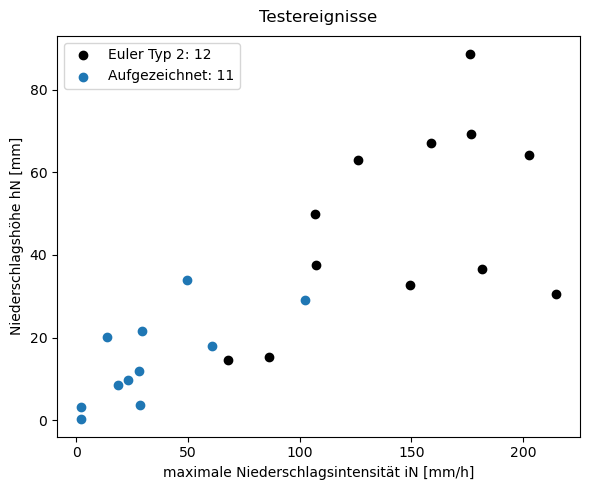

In [4]:
# Extract total precipitation and max intensity from seq_test
seq_test_trans = models[0]['seq_test_trans']
e2_precipitation = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['event type'] == 'Euler Typ 2']
e2_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['event type'] == 'Euler Typ 2']

aufgezeichnet_precipitation = [obj[0]['total precipitation'] for obj in seq_test_trans if obj[0]['event type'] == 'Aufgezeichnet']
aufgezeichnet_intensity = [obj[0]['max intensity'] for obj in seq_test_trans if obj[0]['event type'] == 'Aufgezeichnet']

# Plot events precipitation and intensity in scatterplot
fig, ax2 = plt.subplots(figsize=(6, 5))
ax2.plot( e2_intensity, e2_precipitation,'o', color='black', label='Sample')
ax2.scatter(aufgezeichnet_intensity, aufgezeichnet_precipitation, marker='o',  label='Events')
ax2.set_xlabel('maximale Niederschlagsintensität iN [mm/h]')
ax2.set_ylabel('Niederschlagshöhe hN [mm]')
ax2.set_title('Testereignisse', pad=10)
ax2.legend(labels=['Euler Typ 2: {}'.format(len(e2_precipitation)), 'Aufgezeichnet: {}'.format(len(aufgezeichnet_precipitation))])
plt.tight_layout()


In [5]:
# in_col=1
# out_col=2
# # Keep track of original shapes of in and out data
# in_original_shape = [sample[in_col].shape for sample in seq_test]  
# in_concat = np.concatenate([np.array(sample[in_col]) for sample in seq_test])
# in_concat = np.concatenate([np.array(sequence) for sequence in in_concat])
# # in_concat_flattened = np.reshape(in_concat, (in_concat.shape[0], -1, in_concat.shape[2]))

# out_original_shape = [sample[out_col].shape for sample in seq_test]

# out_concat = np.concatenate([sample[2].reshape(sample[2].shape[0], -1) for sample in seq_test])

# # out_concat = np.concatenate([np.array(sample[out_col]) for sample in seq_test])

# print(in_concat)

# in_invert = in_scaler.inverse_transform(in_concat)
# out_invert = out_scaler.inverse_transform(out_concat)



In [6]:
# # Reshape in_concat back to original shape
# in_invert = np.split(in_concat, np.cumsum([np.prod(shape) for shape in in_original_shape[:-1]]))
# in_invert = [sample.reshape(shape) for sample, shape in zip(in_invert, in_original_shape)]


# # Reshape out_concat back to original shape
# out_invert = np.split(out_concat, np.cumsum([np.prod(shape) for shape in out_original_shape[:-1]]))
# out_invert = [sample.reshape(shape) for sample, shape in zip(out_invert, out_original_shape)]

# seq_test_invert = [(seq_test[i][0], in_invert[i], out_invert[i]) for i in range(len(seq_test))]

# # # Check if the sum of the columns is the same to verify reshaping works properly
# # col_1_sum_seq_test_invert = sum([np.sum(sample[1]) for sample in seq_test_invert])
# # col_1_sum_seq_test = sum([np.sum(sample[1]) for sample in seq_test])
# # col_2_sum_seq_test_invert = sum([np.sum(sample[2]) for sample in seq_test_invert])
# # col_2_sum_seq_test = sum([np.sum(sample[2]) for sample in seq_test])
# # is_same_sum = col_1_sum_seq_test_invert == col_1_sum_seq_test
# # is_same_sum_2 = col_2_sum_seq_test_invert == col_2_sum_seq_test
# # print(is_same_sum, is_same_sum_2)


Durschnittlicher MSE: 
 +-------------+----------+-------------+
|   Modell    | Training | Validierung |
+-------------+----------+-------------+
| "Threshold" | 0.00105  |   0.00102   |
+-------------+----------+-------------+


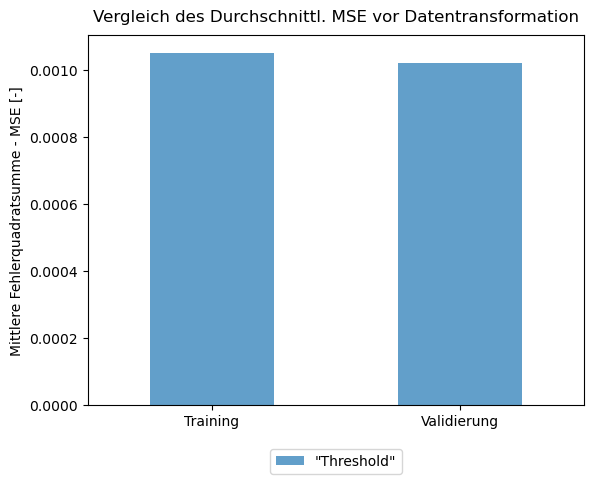

In [7]:
# cross validation results
mse = pd.DataFrame()
metric = 'mse'
metric_upper = metric.upper()
for m in models:
    name = m['print_name']
    train_result = m['cv_scores']['loss'].mean()
    val_result = m['cv_scores']['val_loss'].mean()

    new_row = pd.DataFrame({'Modell':name,'Training': train_result, 'Validierung': val_result}, index=[0])
    mse = pd.concat([mse, pd.DataFrame(new_row)] , ignore_index=True)

ax = mse.set_index('Modell').T.plot.bar(alpha=.7, rot=0, stacked=False)
ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)
ax.set_ylabel('Mittlere Fehlerquadratsumme - '+ metric_upper +' [-]')

ax.set_title('Vergleich des Durchschnittl. '+ metric_upper + ' vor Datentransformation', pad=10)

print('Durschnittlicher MSE: \n',tabulate(round(mse, 5), headers='keys', tablefmt='pretty', showindex=False))
# Show the plot
plt.show()

+-------------+----------+-------------+-------+
|   Modell    | Training | Validierung | Test  |
+-------------+----------+-------------+-------+
| "Threshold" |  0.0734  |   0.0747    | 0.081 |
+-------------+----------+-------------+-------+


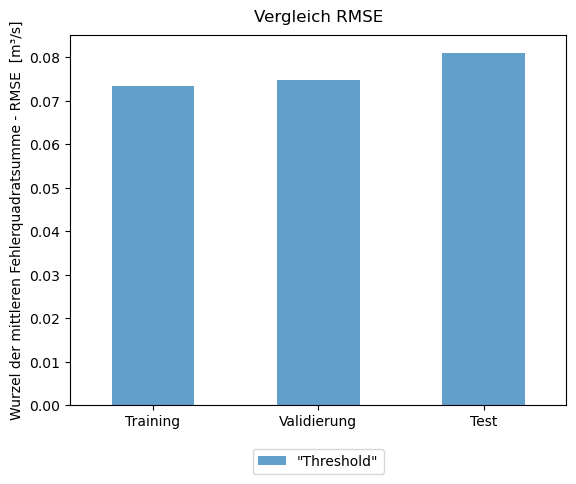

In [8]:
rmse = pd.DataFrame()
metric = 'rmse'
for m in models:
    name = m['print_name']
    train_rmse = m['train_eval'][metric]
    val_rmse = m['val_eval'][metric]
    test_rmse = m['test_eval'][metric]
    new_row = pd.DataFrame({'Modell':name,'Training': train_rmse, 'Validierung': val_rmse, 'Test': test_rmse}, index=[0])
    rmse = pd.concat([rmse, pd.DataFrame(new_row)] , ignore_index=True)

ax = rmse.set_index('Modell').T.plot.bar(alpha=.7, rot=0, stacked=False)
ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)
ax.set_ylabel('Wurzel der mittleren Fehlerquadratsumme - RMSE  [' + out_unit + ']')

ax.set_title('Vergleich RMSE', pad=10)

print(tabulate(round(rmse, 4), headers='keys', tablefmt='pretty', showindex=False))

# Show the plot
plt.show()

+-------------+----------+-------------+--------+
|   Modell    | Training | Validierung |  Test  |
+-------------+----------+-------------+--------+
| "Threshold" |  0.0167  |   0.0171    | 0.0191 |
+-------------+----------+-------------+--------+


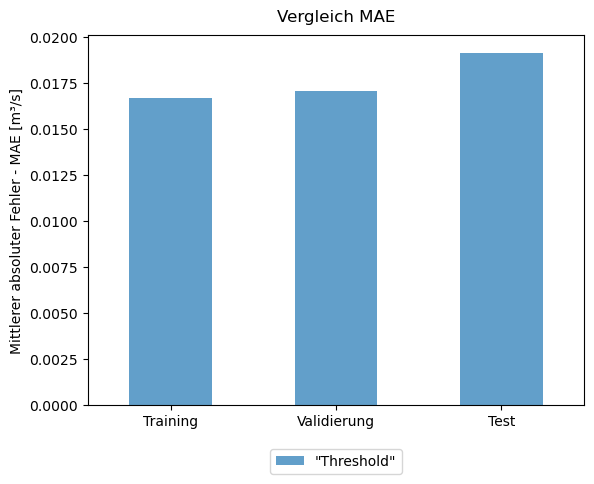

In [9]:
metric = pd.DataFrame()
metric_name = 'mae'
for m in models:
    name = m['print_name']
    train = m['train_eval'][metric_name]
    val = m['val_eval'][metric_name]
    test = m['test_eval'][metric_name]
    new_row = pd.DataFrame({'Modell':name,'Training': train, 'Validierung': val, 'Test': test}, index=[0])
    metric = pd.concat([metric, pd.DataFrame(new_row)] , ignore_index=True)

ax = metric.set_index('Modell').T.plot.bar(alpha=.7, rot=0, stacked=False)
ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)
ax.set_ylabel('Mittlerer absoluter Fehler - MAE [' + out_unit + ']')
ax.set_title('Vergleich MAE', pad=10)

print(tabulate(round(metric, 4), headers='keys', tablefmt='pretty', showindex=False))
plt.show()

- Density plot - abhängigkeit von input daten wird hier wahrscheinlich weniger sichtbar

C:\Users\fl-al\AppData\Local\Temp\ipykernel_25404\1948240334.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


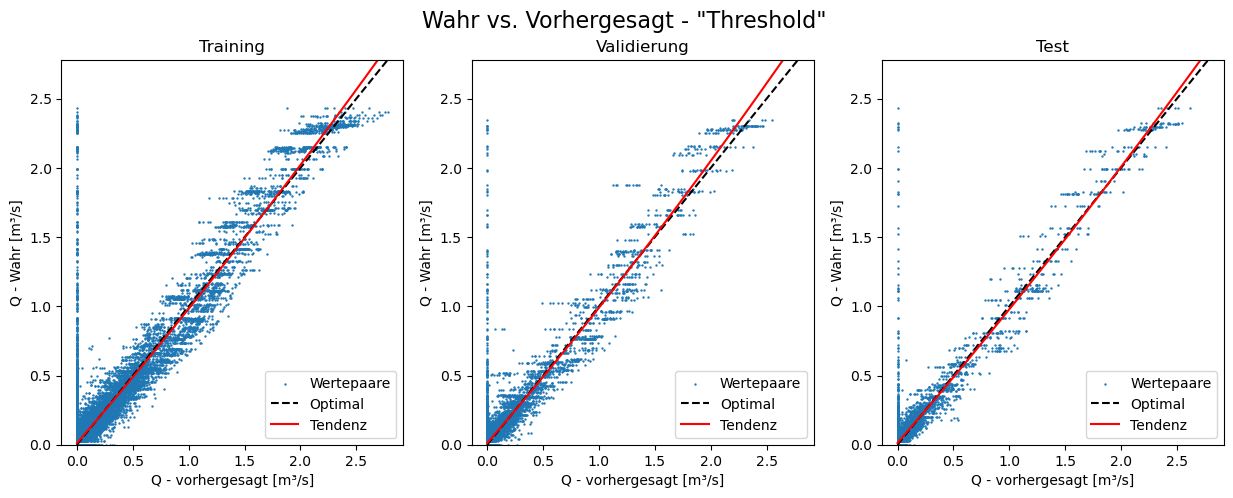

In [10]:
# Plot Resiudals vs Fitted
m_trues = []
m_preds = []
mins =[]
maxs = []
for m in models:
    # Calculate the regression line using polynomial fit
    train_pred_flat = m['train_pred'].flatten()
    train_true_flat = m['train_true'].flatten()
    val_pred_flat = m['val_pred'].flatten()
    val_true_flat = m['val_true'].flatten()
    test_pred_flat = m['test_pred'].flatten()
    test_true_flat = m['test_true'].flatten()
    names = ['Training', 'Validierung', 'Test']
    preds = [train_pred_flat, val_pred_flat, test_pred_flat]
    trues = [train_true_flat, val_true_flat, test_true_flat]
    min_value = min(min(r) for r in preds)
    max_value = max(max(r) for r in preds)
    mins.append(min_value)
    maxs.append(max_value)
    m_preds.append(preds)
    m_trues.append(trues)

min_val = min(mins)
max_val = max(maxs)
regression_range = np.linspace(min_val, max_val, 100)
    
for j in range(len(m_preds)):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    for i in range(len(m_preds[j])):
        # Create a figure and subplots

        reg_line = np.polyfit(m_preds[j][i], m_trues[j][i], 2)
        reg_line_fn = np.poly1d(reg_line)
        # Plot train_pred/train_resid
        axs[i].scatter(m_preds[j][i], m_trues[j][i], marker ='.', s= 2, label = 'Wertepaare')
        axs[i].set_title(names[i])
        axs[i].set_xlabel('Q - vorhergesagt ['+ out_unit + ']')
        axs[i].set_ylabel('Q - Wahr ['+ out_unit + ']')    
        # Plot the average line
        axs[i].plot([0, max_val], [0, max_val], color='black', linestyle='--', label='Optimal')
        # Plot the regression line
        axs[i].plot(regression_range, reg_line_fn(regression_range), color='red', label='Tendenz')
        axs[i].legend()
        axs[i].set_ylim(min_val, max_val)
    # Add a legend
        axs[i].legend()

    fig.suptitle('Wahr vs. Vorhergesagt - ' + models[j]['print_name'], fontsize=16)
    # Show the plot
    fig.show()


C:\Users\fl-al\AppData\Local\Temp\ipykernel_25404\3044875462.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


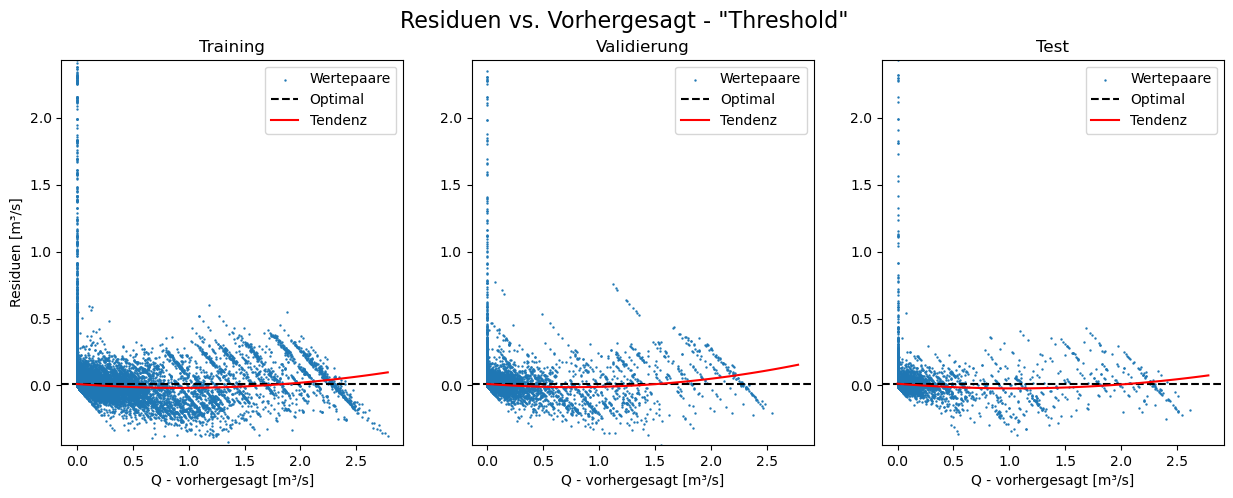

In [11]:
# Plot Resiudals vs Fitted
m_resids = []
m_preds = []
mins =[]
maxs = []
maxs_preds = []
for m in models:
    # Calculate the regression line using polynomial fit
    train_pred_flat = m['train_pred'].flatten()
    train_resid = m['train_resid']
    val_pred_flat = m['val_pred'].flatten()
    val_resid = m['val_resid']
    test_pred_flat = m['test_pred'].flatten()
    test_resid = m['test_resid']
    names = ['Training', 'Validierung', 'Test']
    preds = [train_pred_flat, val_pred_flat, test_pred_flat]
    resids = [train_resid, val_resid, test_resid]
    min_value = min(min(r) for r in resids)
    max_value = max(max(r) for r in resids)
    max_pred = max(max(p) for p in preds)
    mins.append(min_value)
    maxs.append(max_value)
    maxs_preds.append(max_pred)
    m_preds.append(preds)
    m_resids.append(resids)

max_pred_val = max(maxs_preds)
min_val = min(mins)
max_val = max(maxs)
regression_range = np.linspace(0, max_pred_val, 100)

for j in range(len(m_preds)):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    for i in range(len(m_preds[j])):
        # Create a figure and subplots
        
        reg_line = np.polyfit(m_preds[j][i], m_resids[j][i], 2)
        reg_line_fn = np.poly1d(reg_line)
        # Plot train_pred/train_resid
        axs[i].scatter(m_preds[j][i], m_resids[j][i], marker ='.', s= 2,label='Wertepaare')
        axs[i].set_title(names[i])
        axs[i].set_xlabel('Q - vorhergesagt ['+ out_unit + ']')
        if i == 0:
            axs[i].set_ylabel('Residuen ['+ out_unit + ']')
        # Plot the average line
        axs[i].axhline(np.mean(m_resids[j][i]), color='black', linestyle='--', label='Optimal')
        # Plot the regression line
        axs[i].plot(regression_range, reg_line_fn(regression_range), color='red', label='Tendenz')
        axs[i].legend()
        axs[i].set_ylim(min_val, max_val)
    # Add a legend
        axs[i].legend()

    fig.suptitle('Residuen vs. Vorhergesagt - ' + models[j]['print_name'], fontsize=16)
    # Show the plot
    fig.show()


In [12]:
n_sample = 3
n = 15
# test for plot_seq_i_d_Q function
for m in models:
    seq_test = m['seq_test']
    seq_test_trans = m['seq_test_trans']
    model = m['model']

    interval = seq_test[n_sample][0]['interval']
    meta = seq_test[n_sample][0]
    in_seq = seq_test[n_sample][1][n]
    out_act = seq_test[n_sample][2][n]

    # Calculate the start and end time of the sequence so that a duration column can be created
    start_time = max(seq_test[n_sample][1][n][:, 0]) + interval + delay * interval
    end_time = start_time + p_steps * interval
    duration_col = np.arange(start_time, end_time, interval)

    Predict = model.predict(seq_test_trans[n_sample][1])
    Predict_invert = out_scaler.inverse_transform(Predict)

    predict_seq = np.column_stack((duration_col,Predict_invert[n]))
    actual_seq = np.column_stack((duration_col,out_act))


    plot_seq_i_d_Q(in_seq, actual_seq, predict_seq, meta, interval,).show()

IndexError: index 15 is out of bounds for axis 0 with size 11

+-------------------+----------+-------------+--------+
|      Modell       | Training | Validierung |  Test  |
+-------------------+----------+-------------+--------+
| "Shuffle = False" |  0.0228  |   0.0209    | 0.0273 |
| "Shuffle = True"  |  0.0112  |   0.0115    | 0.0129 |
+-------------------+----------+-------------+--------+


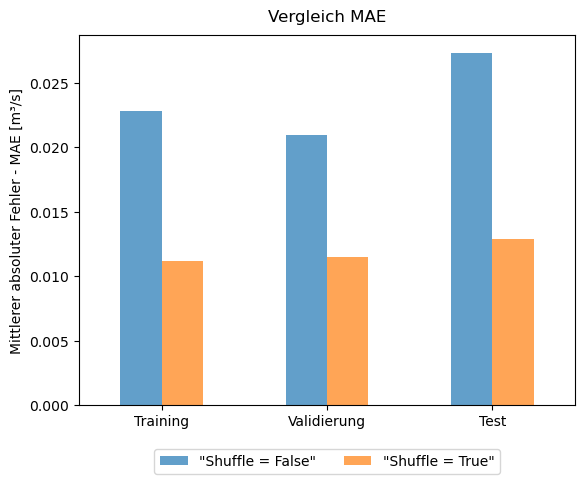

In [ ]:
# Plot metrics based on output range on the testset
metric = pd.DataFrame()
metric_name = 'mae'
for m in models:
    name = m['print_name']
    train = m['train_eval'][metric_name]
    val = m['val_eval'][metric_name]
    test = m['test_eval'][metric_name]
    new_row = pd.DataFrame({'Modell':name,'Training': train, 'Validierung': val, 'Test': test}, index=[0])
    metric = pd.concat([metric, pd.DataFrame(new_row)] , ignore_index=True)

ax = metric.set_index('Modell').T.plot.bar(alpha=.7, rot=0, stacked=False)
ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3)
ax.set_ylabel('Mittlerer absoluter Fehler - MAE [' + out_unit + ']')
ax.set_title('Vergleich MAE', pad=10)

print(tabulate(round(metric, 4), headers='keys', tablefmt='pretty', showindex=False))
plt.show()


In [ ]:
# Metrics based on Output magnitude

test_true_flattened = models[0]['test_true'].flatten()
test_pred_flattened = models[0]['test_pred'].flatten()

test_stack_flat = np.column_stack((test_true_flattened, test_pred_flattened))

print(len(test_stack_flat))
test_stack_flat = test_stack_flat[test_stack_flat[:, 0] != 0]
test_stack_flat = pd.DataFrame(test_stack_flat, columns=['True', 'Pred'])

# Get the value range of test_stack['True']
value_range = np.ptp(test_stack_flat['True'])

# Split the value range into 4 equal ranges
ranges = np.linspace(0, np.max(test_stack_flat['True']), num=11)


test_stack_flat['Bins'] = pd.cut(test_stack_flat['True'], bins=ranges, labels=False, include_lowest=True)
ranges = np.round(ranges, 2)

# Get unique bins
unique_bins = test_stack_flat['Bins'].unique()
unique_bins = sorted(unique_bins)



# Create a list to store the datasets
bins = []

# Iterate over each unique bin
for bin_num in unique_bins:
    # Filter the dataframe for the current bin
    bin_data = test_stack_flat[test_stack_flat['Bins'] == bin_num].copy()
    
    # Append the filtered dataset to the list
    bins.append(bin_data)

metrics = pd.DataFrame(columns=['Bin', 'MSE','RMSE', 'MAE', 'MAPE', 'start', 'end', 'False_0', 'n'])
i = 0
for bin in bins:
    mse = np.mean((bin['True'] - bin['Pred'])**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(bin['True'] - bin['Pred']))
    mape = np.mean(np.abs((bin['True'] - bin['Pred']) / bin['True'])) * 100
    bin_start = ranges[i]
    bin_end = ranges[i+1]
    False_0 = len(bin[bin['Pred'] == 0])
    n = len(bin)

    new_row = pd.DataFrame({'Bin':i, 'MSE':mse,'RMSE':rmse, 'MAE':mae, 'MAPE':mape, 'start':bin_start, 'end':bin_end, 'False_0': False_0, 'n':n}, index=[0])

    i +=1
    
    metrics = pd.concat([metrics,new_row], ignore_index=True)

metrics


30492


C:\Users\fl-al\AppData\Local\Temp\ipykernel_23944\1257587098.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics,new_row], ignore_index=True)


,Bin,MSE,RMSE,MAE,MAPE,start,end,False_0,n
0,0,0.001251,0.035372,0.023553,1203.462303,0.00,0.24,20084,26044
1,1,0.023794,0.154254,0.121917,37.552691,0.24,0.49,54,612
2,2,0.052875,0.229945,0.168845,27.829568,0.49,0.73,15,216
3,3,0.038773,0.196909,0.144799,17.491115,0.73,0.97,0,96
4,4,0.044322,0.210528,0.171318,15.675253,0.97,1.22,0,120
5,5,0.052526,0.229185,0.198173,15.282713,1.22,1.46,0,48
6,6,0.046131,0.214781,0.176387,11.544078,1.46,1.70,0,36
7,7,0.060431,0.245827,0.213105,11.734370,1.70,1.95,0,60
8,8,0.103387,0.321539,0.276416,13.295078,1.95,2.19,0,72
9,9,0.076723,0.276989,0.237045,10.187569,2.19,2.43,0,84


C:\Users\fl-al\AppData\Local\Temp\ipykernel_25404\3884783257.py:74: RuntimeWarning: invalid value encountered in scalar divide
  abs_prct_errors[i] = np.append(abs_prct_errors[i], extreme_abs_error / actual_max * 100)
C:\Users\fl-al\AppData\Local\Temp\ipykernel_25404\3884783257.py:74: RuntimeWarning: invalid value encountered in scalar divide
  abs_prct_errors[i] = np.append(abs_prct_errors[i], extreme_abs_error / actual_max * 100)


IndexError: index -6 is out of bounds for axis 0 with size 3

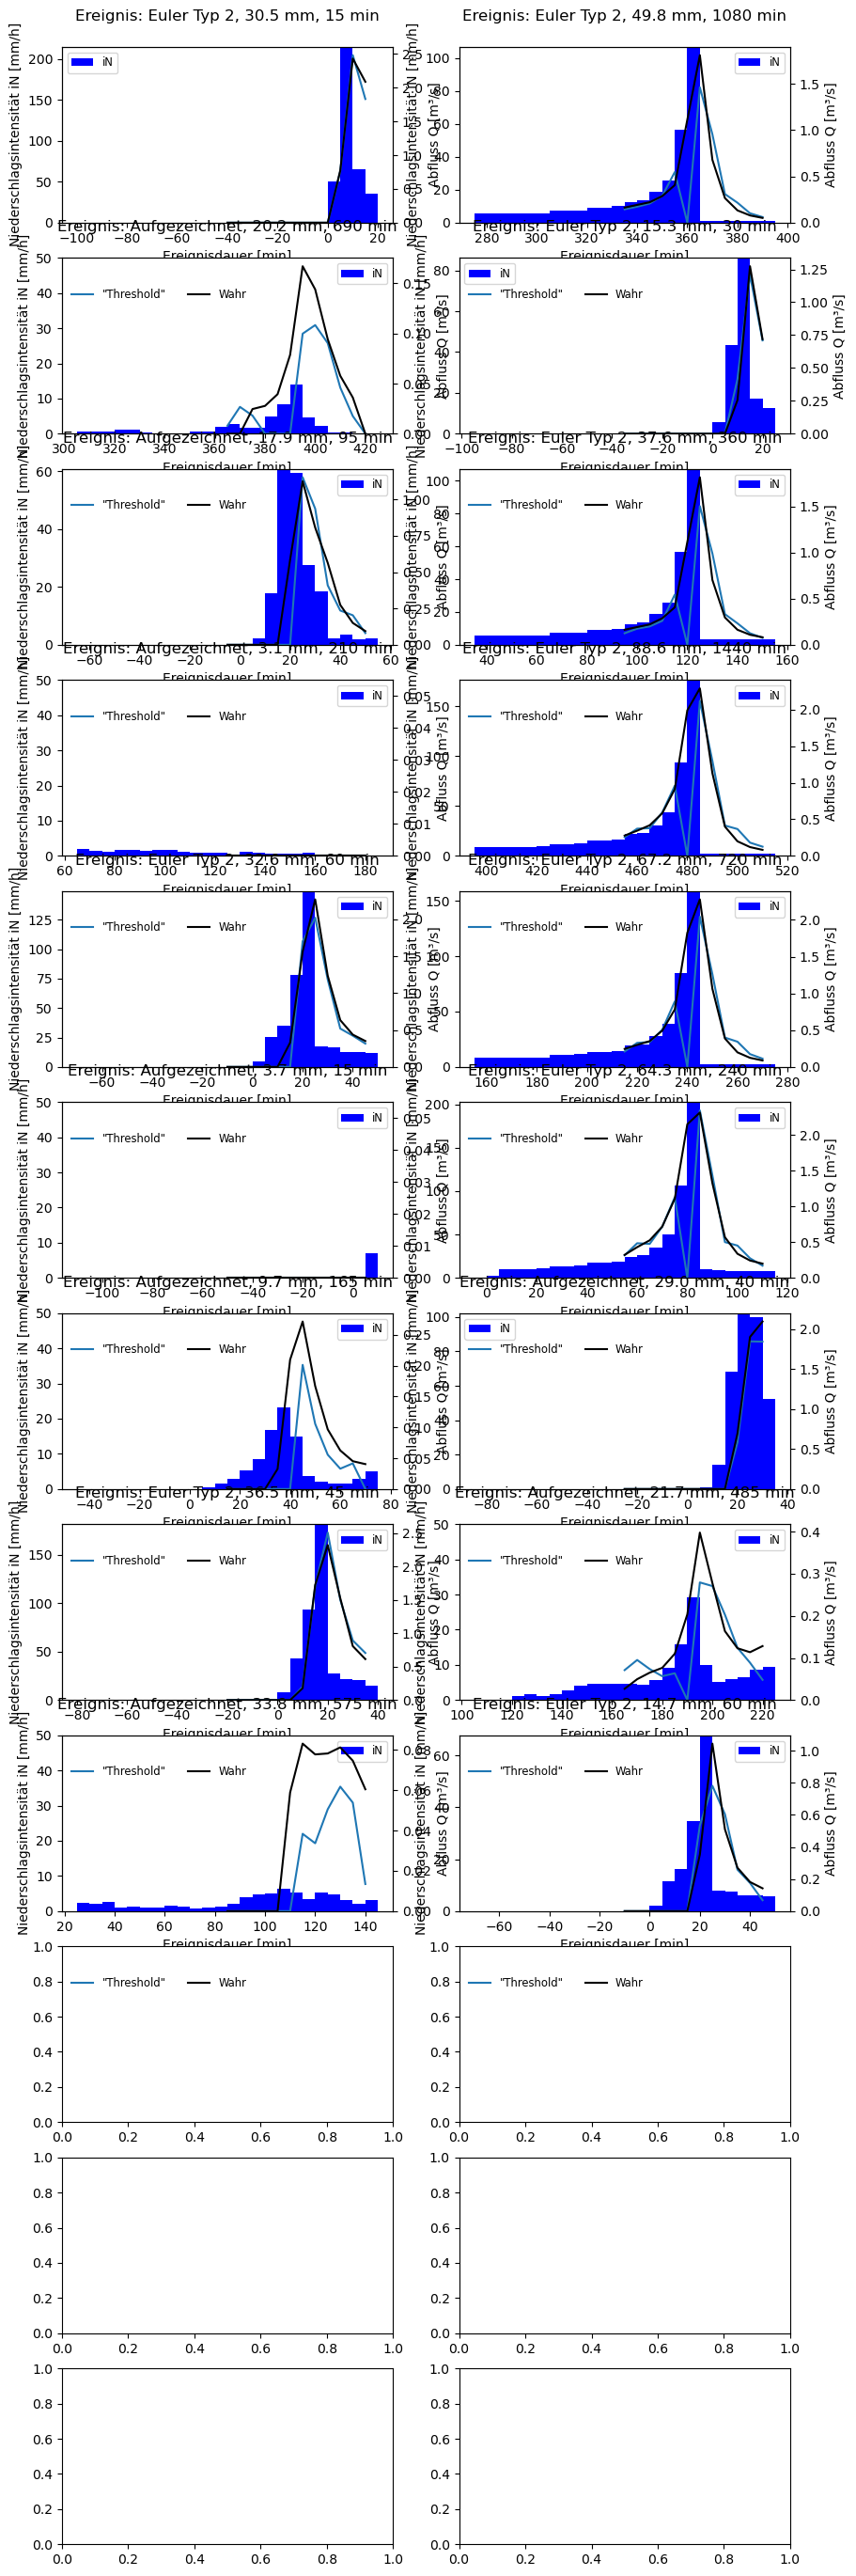

In [13]:

#retrieve the interval of the time steps
interval = models[0]['seq_test'][0][0]['interval']

# Create a grid of subplots
plot_rows = int(len(seq_test_trans)/2+1)
fig, axs = plt.subplots(plot_rows, 2, figsize=(10, 1.5*len(seq_test_trans)))

abs_errors = [np.array([]) for _ in range(len(models))]
sqrt_errors = abs_errors.copy()
abs_prct_errors = abs_errors.copy()
# Loop through n_sample
for n_sample in range(len(seq_test_trans)):
    # n = 12 +int((len(seq_test[n_sample][1])-24) / 3)
    # n = int(len(seq_test[n_sample][1]) / 5)
    n = np.argmax(seq_test[n_sample][2][:, 0, 0])
    n = n - p_steps/2
    n = n.astype(int)

    # Calculate the start and end time of the sequence so that a duration column can be created
    start_time = max(seq_test[n_sample][1][n][:, 0]) + interval + delay * interval
    end_time = start_time + p_steps * interval
    duration_col = np.arange(start_time, end_time, interval)

    actual_seq = np.column_stack((duration_col,seq_test[n_sample][2][n]))
    
    # Dictionary of event meta data
    meta = seq_test[n_sample][0] #'name': sample_name, 'duration': event_duration, 'total precipitation': precip_sum, 'max intensity': max_intensity, 'interval': intervall, 'Ereignis': type

    # Calculate column index for the subplot. Only important for plot!!
    col_index = n_sample % 2
 
    # Create Barplot of Precipitation
    ax1 = axs[n_sample // 2, col_index]
    ax1.set_title(f"Ereignis: {meta['event type']}, {round(meta['total precipitation'],1)} mm, {meta['duration']} min", pad=20)
    x = seq_test[n_sample][1][n][:,0]  # Set x-axis values
    ax1.bar(x, seq_test[n_sample][1][n][:,1], color='blue', label='iN', width=interval, align='edge')
    top_lim = max(max(seq_test[n_sample][1][n][:,1]), 50)
    ax1.set_ylim(bottom=0, top=top_lim)  # Set y-axis to start from zero
    ax1.set_ylabel('Niederschlagsintensität iN [mm/h]')
    ax1.set_xlabel('Ereignisdauer [min]')
    ax1.legend(fontsize = 'small')

    # Create a twin axis on the right side
    # Plotting the predicted and actual values in the corresponding subplot
    ax2 = ax1.twinx()
    i = 0
    for m in models:
        seq_test = m['seq_test']
        seq_test_trans = m['seq_test_trans']
        model = m['model']

        interval = seq_test[n_sample][0]['interval']
        meta = seq_test[n_sample][0]
        in_seq = seq_test[n_sample][1][n]
        out_act = seq_test[n_sample][2][n]

        # Calculate the start and end time of the sequence so that a duration column can be created
        start_time = max(seq_test[n_sample][1][n][:, 0]) + interval + delay * interval
        end_time = start_time + p_steps * interval
        duration_col = np.arange(start_time, end_time, interval)

        Predict = model.predict(seq_test_trans[n_sample][1], verbose=0)
        Predict_invert = out_scaler.inverse_transform(Predict)

        predict_seq = np.column_stack((duration_col,Predict_invert[n]))
        ax2.plot(predict_seq[:, 0], predict_seq[:, 1], label=m['print_name'])
        argmax = np.argmax(actual_seq[:, 1])
        actual_max = actual_seq[argmax, 1]
        predict_max = predict_seq[argmax, 1]
        extreme_abs_error = abs(actual_max - predict_max)
        extreme_squared_error = extreme_abs_error**2
        sqrt_errors[i] = np.append(sqrt_errors[i], extreme_squared_error)
        abs_errors[i] = np.append(abs_errors[i], extreme_abs_error)
        abs_prct_errors[i] = np.append(abs_prct_errors[i], extreme_abs_error / actual_max * 100)
        i+=1

    ax2.plot(actual_seq[:, 0], actual_seq[:, 1], color = 'black', label='Wahr')
    ax2.set_ylim(bottom=0)  # Set y-axis to start from zero
    ax2.set_ylabel('Abfluss Q [m³/s]')
    ax2.legend(loc='lower left', bbox_to_anchor=(0, -0.5), frameon=False, ncol = len(models)+1, fontsize = 'small')
    
peak_maes = []
peak_rmses = []
peak_mapes = []

for i in range(len(abs_errors)):
    mae = np.mean(abs_errors[i])
    rmse = np.sqrt(np.mean(sqrt_errors[i]))
    mape = np.mean(abs_prct_errors[i])
    peak_maes.append(mae)
    peak_rmses.append(rmse)
    peak_mapes.append(mape)

peak_eval = pd.DataFrame({
    'Modell': [models[i]['print_name'] for i in range(len(models))],
    'MAE [-]': peak_maes,
    'RMSE [-]': peak_rmses,
    'MAPE [%]': peak_mapes
})

print('Auswertung der Extremwertabweichung im Testdatensatz: \n', tabulate(peak_eval, headers='keys', tablefmt='psql', showindex=False))

plt.tight_layout()
# Show the plot
plt.show()


Eigener Auswerteparameter:
mae  aller Maximalabflüsse im Testdatensatz 